# Homework 1 - Ngrams
CSCI6030  
Mike Finch

## Assignment  
Review a corpus and gather statistics of the information.
1. Letter Frequency
1. Zipf's Law
1. Most Frequent Words
1. Most Frequent Bigrams
1. Most Frequent TriGrams
1. Self Assessment
1. Testing

### First load the documents.

In [1]:
# Get the list of files
from glob import glob

files = glob('./gutenberg-corpus/**/*.txt', recursive=True)

### Clean each line of each document
1. Make lower case
1. Remove punctuation
1. Handle apostrophes
    1. Handle contracions before possessives
        1. Replace it's with it is.
        1. Replace they'll, I'll, you'll with <x> will.
        1. Replace you're, they're with <x> are.
    1. Handle possessives
        1.  Remove 's
        1.  Replace s' with s
    1. Handle common contractions
        1. Stopped at point of diminishing returns
        1. Some words like o'clock, ma'am make more sense than "of the clock" or "madame".
Function below will be used to clean each line when it's loaded  

In [2]:
#clean a line
def cleanALine(line):
    line = line.lower()
    #get rid puncuation & numbers except apostrophes
    for char in '-_.,:;?!()[]{}<>=*$&0123456789`\"\n':
        line=line.replace(char,' ')
    #trade run time of checking string for apostrophes once vs time of remaining checks
    #maybe could do again, but that might be over optimization.
    if '\'' not in line:
        return line
    line = ' '+line+' '  # makes sure word boundry checks work on i's and last words
    #fix it's, 'tis' -> it is
    line = line.replace('it\'s', 'it is ')
    line = line.replace('\'tis', 'it is ')    
    line = line.replace('\'twas ', 'it was ')    
    line = line.replace('\'twill ', 'it will ')    
    line = line.replace('\'twould ', 'it would ')    
    #fix you'll -> you will etc...
    line = line.replace('\'ll ', ' will ')
    #fix you're -> you are etc...
    line = line.replace('\'re ', ' are ' )
    #fix i've you've, they've -> I have..
    line = line.replace('\'ve ', ' have ')
    #eliminate trailing 's
    line = line.replace('\'s ', ' ')
    #eliminate plural pssessive s' and trailing quotes
    line = line.replace('\' ', ' ')
    #eliminate beginning quotes  #The beginning of line check has to be after the 'tis check
    line = line.replace(' \'',' ')
    #There are some apostrohes that we do not want to clean, like ain't and o'clock
    #so we have to be careful with the patterns going forward.
    #fix won't, can't, shan't
    line = line.replace(" won't ", " would not ")
    line = line.replace(" can't ", " can not ")
    line = line.replace(" shan't ", " should not ")
    #fix shouldn't, couldn't, doesn't -> should not...
    line = line.replace('n\'t ', ' not ')  
    #fix i'm, i'd
    line = line.replace('i\'m ', 'i am ')
    line = line.replace('i\'d ', 'i would ')
    line = line.replace('e\'d ', 'e would ') # picks up we'd he'd and she'd
    line = line.replace(" they'd ", " they would ")
    line = line.replace(" you'd ", " you would ")
    #fix 'd for ed sufix
    line = line.replace('\'d ', 'ed ')
    #fix e'er, e'en, o'er...
    line = line.replace('\'e', 've')
    return line

### Collect Letter Counts
We will use an array structure to hold the letters.
Function below will be used to add data to the structure.  

In [3]:
# Create an array for letter counts
letters = [0]*26
alphabet = 'abcdefghijklmnopqrstuvwxyz'

# Create a function to capture letters
def addWordToLetters(word):
    global needsCleaning
    for char in word:
        if char in alphabet:
            index = alphabet.index(char)
            letters[index] +=1
        else:
            if word not in {"o'clock","ain't", "ma'am"}:
                needsCleaning += 1
#                print("Needs to clean "+ word)
  

### Collect N-gram counts
Create a dictionary to hold unigrams, bigrams, trigrams

In [4]:
# Create a dictionary for words
unigrams = {}
bigrams = {}
trigrams = {}

#previous words to create ngrams
before = None
twobefore = None

#Create a function to store words
def addWordsToBag(words):
    global before, twobefore
    for word in words:
        unigrams[word] = unigrams.get(word, 0) + 1
        addWordToLetters(word)
        if before is not None:
            key = before+" "+word
            bigrams[key] = bigrams.get(key,0) + 1
            if twobefore is not None:
                key = twobefore+' '+before+' '+word
                trigrams[key] = trigrams.get(key,0) + 1
            twobefore = before
        before = word
#reset globals becuase we don't want the last word of one document to be paired with the first word of the next.        
def endOfDoc():
    global before, twobefore
    before = None
    twobefore = None

### Load Data
The loop below loads each file and reads the lines one at a time. Then calls the function to load the data.

In [5]:
needsCleaning = 0
for file in files:
    with open(file) as f:
        while True:
            try :
                line1 = next(f)
            except StopIteration:
                break
            line = cleanALine(line1)
            words = line.split()
            addWordsToBag(words)
        endOfDoc()
print("Down to ",needsCleaning," words that could be cleaned.")

Down to  605  words that could be cleaned.


<div style="page-break-after: always;"></div>
## Letter Frequency
Plot the relative frequency of each letter

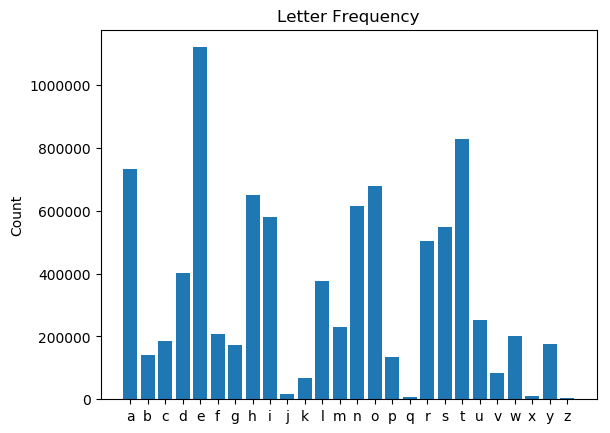

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcdefaults()
x_pos = np.arange(26)
performance = letters
 
plt.bar(x_pos ,performance, align='center')
plt.xticks(x_pos, alphabet)
plt.ylabel('Count')
plt.title('Letter Frequency')
 
plt.show()

<div style="page-break-after: always;"></div>
##  Zipfs' Law
Zipfs' law says that the frequency of words are power law distributed. To show this we can plot on a log-log plot, it should approximate a straight line.


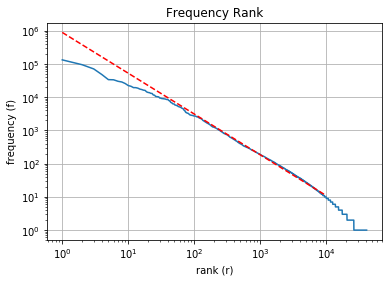

In [7]:
from collections import Counter
from pylab import *
sorted = Counter(unigrams).most_common()
word_count = []
for word in sorted:
    word_count.append(word[1])
x = np.arange(1,len(unigrams)+1)
loglog(x, word_count)


#Fit Line
LogX = np.log(x[:10000])
LogY = np.log(word_count[:10000])

m,c = np.polyfit(LogX, LogY, 1)
Fitted = np.exp(m*LogX +c)

loglog(x[:10000], Fitted, color = 'red', linestyle = 'dashed')


xlabel('rank (r)')
ylabel('frequency (f)')
title('Frequency Rank')
grid(True)
show()


It appears that word distribution approximates Zipfs' law, but it does not apply at either extreme.  The most common words are not common enough, and their should be far more words only used rarely.


## Top 10 Words
Unigrams are already sorted, so print out the first 10.

In [8]:
print('{:_<20} {:_>10}'.format("Word", "Count"))
for i in range(10):
    print('{:<20} {:>10}'.format(sorted[i][0], sorted[i][1]))

Word________________ _____Count
the                      133567
and                       95428
of                        71256
to                        47965
a                         33928
in                        33550
i                         30271
that                      28803
he                        25890
it                        22511


Looks like most of the top 10 are "stop words".

## Top 10 bigrams
Sort the collection of bigrams and print out the top 10 

In [9]:
from collections import Counter
sorted = Counter(bigrams).most_common()
print('{:_<20} {:_>10}'.format("Bigram", "Count"))
for i in range(10):
    print('{:<20} {:>10}'.format(sorted[i][0], sorted[i][1]))

Bigram______________ _____Count
of the                    19142
in the                    10243
and the                    8877
the lord                   7081
to the                     5407
all the                    3598
and he                     3595
to be                      3469
it is                      3267
for the                    3048


## Top 10 trigrams
Sort the collection of trigrams and print out the top 10

In [10]:
from collections import Counter
sorted = Counter(trigrams).most_common()
print('{:_<25} {:_>10}'.format("Trigram", "Count"))
for i in range(10):
    print('{:<25} {:>10}'.format(sorted[i][0], sorted[i][1]))

Trigram__________________ _____Count
of the lord                     1780
the son of                      1469
the children of                 1369
out of the                      1202
the house of                     918
saith the lord                   854
the lord and                     829
and i will                       818
i do not                         702
and all the                      697


## Self Assessment
|Task |Max Points Possible|Points Earned|
|---|---|---|
|Program compiles and runs |30 | 30|
|Program seems to produce correct results |20 | 20|  
|Testing is done and test results are documented|20 | 20|
|Appropriate data types are chosen for variables|10 | 10|
|Variable names are self-explanatory |10 | 10|
|Program code is commented appropriately |  5 |  5|
|Self-assessment is performed |5 |n|
|Total points |100 |100|


## Testing

### Initial Development
The program was developed in the notebook using a test corpus.  Notebooks add a challenge becuase of the difficulty of creating unit tests.  A path would have ben to develop the functions in an IDE and unit test them, and then copy/paste into the notebook.  That would have required discipline to keep the notebook and IDE code in synch.  
Instead I chose to add documents to the test corpus one at a time to validate the basic function, and then tune it on the gutenberg corpus.  This does result in some overfitting to the gutenberg corpus, but that seems appropriate in a notebook. The test corpus corpus was a set of trivial documents to verify that each portion of the program worked.

In [11]:
files = glob('./temp/*.txt')
for file in files:
    print(file)

./temp/fox.txt
./temp/postrophe.txt
./temp/test.txt


#### The first file `test.txt`  
This was a simple sentance to validate the parsing that could easily be checked by eyeball:  
- letters were counted
- unigrams, bigrams, and trigrams created  
- punctuation stripped
- words lower cased

In [12]:
with open('./temp/test.txt', 'r') as testFile:
    test = testFile.read()
print(test)

This is a test.



#### The next file `fox.text` 
This is a classic typing sentance that contains all the letters in the alphabet.  It verified that all letters were counted.  It also tested that bigrams and trigrams wrapped around lines, but not between documents.

In [13]:
with open('./temp/fox.txt', 'r') as testFile:
    fox = testFile.read()
print(fox)

The quick brown fox
jumped over the lazy dog.



#### The final file `postrophe.txt`
This added the initial touches on the filtering apostrophes.  The sentances were added to it one at a time.  The first sentance handles possessives, and disambiguates them from it's -> it is.  The second sentance confimed that my approach to handling contractions would work.

In [14]:
with open('./temp/postrophe.txt', 'r') as testFile:
    postrophe = testFile.read()
print(postrophe)

It's hard to see Steve's dogs' leashes. 
You're lucky you'll walk again.



### Contraction Handling in corpus.

This is where the notebook is overfit to the document.  Instead of trying to handle all the common English contractions, I editied the notebook to print out the contraction's that it found.  Everytime I tried to add a character to the letter data structure and it was not a letter, I printed the word that contained it.  I also kept track of the number of such occurances and removed them one at a time until I got to the point of diminishing returns.  